In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
sns.set(font_scale=1.3)

**************************************************

Baseline param sweep -- large goods

**************************************************

In [2]:
dfpairs = pd.read_pickle("param_sweep_pairs.pkl",compression='bz2')
dfpairs['NRecovered'] = dfpairs['FracRecovered']*dfpairs['NStaff']
print(dfpairs.columns,'\n')

Index(['Group', 'NStaff', 'Iteration', 'FracRecovered', 'FomiteInfectionFrac',
       'CohortInfectionFrac', 'RandContactInfectionFrac', 'PairInfectionFrac',
       'RoomInfectionFrac', 'ExtIntroFrac', 'CustIntroFrac', 'CarShareInfFrac',
       'HouseShareInfFrac', 'CustomersInfected', 'IsolatorsFrac',
       'SympIsolatorsFrac', 'FPIsolatorsFrac', 'TPSympIsolatorsFrac',
       'TPAsympIsolatorsFrac', 'IndexCaseInfections', 'IndexCaseViralLoad',
       'IndexCaseInfectivity', 'OverallOutbreakLength', 'fixed_loader_pairs',
       'Dtime', 'Ltime', 'fixed_driver_pairs', 'tD', 'SimType',
       'BreakContactProb', 'TeamTimes', 'PkgHlife', 'phi', 'TeamDistances',
       'is_driver_pairs', 'InfInit', 'HouseShareFactor', 'CarShareFactor',
       'Psusc', 'Pisol', 'NDteams', 'is_cohorts', 'is_loader_pairs',
       'p_contact', 'CohortChangeRate', 'p_fomite_trans', 'is_window_open',
       'NOteams', 'TeamsOutside', 'NLteams', 'NRecovered'],
      dtype='object') 



In [3]:
job = ['Driver','Picker','Office']
dfall = dfpairs[dfpairs["Group"]=='All']
dfall['outbreak'] = (dfall['NRecovered'] > 4)
dfall['Ninfected'] = (dfall.loc[:,'FracRecovered']*dfall.loc[:,'NStaff'] - 1)
dfall['InfJob'] = np.ones(len(dfall),dtype=np.object)
for i in np.arange(3):
    dfall.loc[dfall['InfInit']==i+1,'InfJob'] = job[i]
dfNDT = dfall[(dfall['NLteams'] == 2) & (dfall['NOteams'] == 1)] 
dfNLT = dfall[(dfall['NDteams'] == 3) & (dfall['NOteams'] == 1)] 
dfNOT = dfall[(dfall['NDteams'] == 3) & (dfall['NLteams'] == 2)]

/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is tr

In [4]:
II = np.unique(dfpairs["InfInit"])
FP = np.unique(dfpairs["fixed_driver_pairs"])
WO = np.unique(dfpairs["is_window_open"])
TDists = np.unique(dfpairs["TeamDistances"])
NDteams = np.unique(dfpairs["NDteams"])
NLteams = np.unique(dfpairs["NLteams"])
NOteams = np.unique(dfpairs["NOteams"])
print('II = ', II)
print('TDists = ', TDists)
print('FDP = ', FP)
print('WO = ', WO)

#parameter reminder
print('TD = ', np.unique(dfpairs["tD"]))
print('Phi = ', np.unique(dfpairs['phi']))
print('Pisol = ', np.unique(dfpairs['Pisol']))
print('Random contact rate = ', np.unique(dfpairs['p_contact']))
print('Cohort shuffle rate = ', np.unique(dfpairs['CohortChangeRate']))
print('Staff totals = ', np.unique(dfpairs['NStaff']))
print(np.sum(dfpairs["NDteams"]==3))
print(np.sum(dfpairs["NLteams"]==2))
print(np.sum(dfpairs["NOteams"]==1))

II =  [1 2 3]
TDists =  [1.]
FDP =  [False  True]
WO =  [False  True]
TD =  [0.1]
Phi =  [1.]
Pisol =  [0.5]
Random contact rate =  [0.04545455]
Cohort shuffle rate =  [0.02272727]
Staff totals =  [ 8 16 20 44]
2880000
2880000
3360000


breakdown of infection causes in the model

In [5]:
job = ['Driver','Picker','Office']
jobtypes = np.unique(dfpairs['Group'])
dfh = dfpairs.loc[lambda dfpairs: (dfpairs['NDteams']==3)*(dfpairs['NLteams']==2)*\
                  (dfpairs['NOteams']==1)]
netinfs = np.zeros((len(jobtypes),len(II),len(FP),len(WO)))
continfs = np.zeros((len(jobtypes),len(II),len(FP),len(WO)))
roominfs = np.zeros((len(jobtypes),len(II),len(FP),len(WO)))
carinfs = np.zeros((len(jobtypes),len(II),len(FP),len(WO)))
houseinfs = np.zeros((len(jobtypes),len(II),len(FP),len(WO)))
pairinfs = np.zeros((len(jobtypes),len(II),len(FP),len(WO)))
fomiteinfs = np.zeros((len(jobtypes),len(II),len(FP),len(WO)))
for (n, g) in enumerate(jobtypes):
    dfg = dfh.loc[lambda dfh: (dfh['Group'] == g)]
    for (j,ii) in enumerate(II):
        dfij =  dfg.loc[lambda dfg: (dfg['InfInit'] == ii)]
        for (k,fp) in enumerate(FP):
            dfijk =  dfij.loc[lambda dfij: (dfij['fixed_driver_pairs'] == fp)]
            for (l,wo) in enumerate(WO):
                dfijkl = dfijk.loc[lambda dfijk: (dfijk['is_window_open'] == wo)]
                fomiteinfs[n,j,k,l] = np.mean(dfijkl['FomiteInfectionFrac']*dfijkl['NStaff'])
                netinfs[n,j,k,l] = np.mean(dfijkl['CohortInfectionFrac']*dfijkl['NStaff'])
                continfs[n,j,k,l] = np.mean(dfijkl['RandContactInfectionFrac']*dfijkl['NStaff'])
                roominfs[n,j,k,l] = np.mean(dfijkl['RoomInfectionFrac']*dfijkl['NStaff'])
                carinfs[n,j,k,l] = np.mean(dfijkl['CarShareInfFrac']*dfijkl['NStaff'])
                houseinfs[n,j,k,l] = np.mean(dfijkl['HouseShareInfFrac']*dfijkl['NStaff'])
                pairinfs[n,j,k,l] = np.mean(dfijkl['PairInfectionFrac']*dfijkl['NStaff'])
                        
# for (i,td) in enumerate(TD):
#     for (j,ii) in enumerate(II):
#         for (k,fp) in enumerate(FP):
#             for (l,wo) in enumerate(WO):
#                 for (m,pi) in enumerate(PI):                        
#                     norm = netinfs[jobtypes=='All',i,j,k,l,m][0] + \
#                             continfs[jobtypes=='All',i,j,k,l,m][0] + \
#                             roominfs[jobtypes=='All',i,j,k,l,m][0] + \
#                             pairinfs[jobtypes=='All',i,j,k,l,m][0]
#                     if norm > 0:
#                         netinfs[:,i,j,k,l,m] /= norm
#                         continfs[:,i,j,k,l,m] /= norm
#                         roominfs[:,i,j,k,l,m] /= norm
#                         pairinfs[:,i,j,k,l,m] /= norm

/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


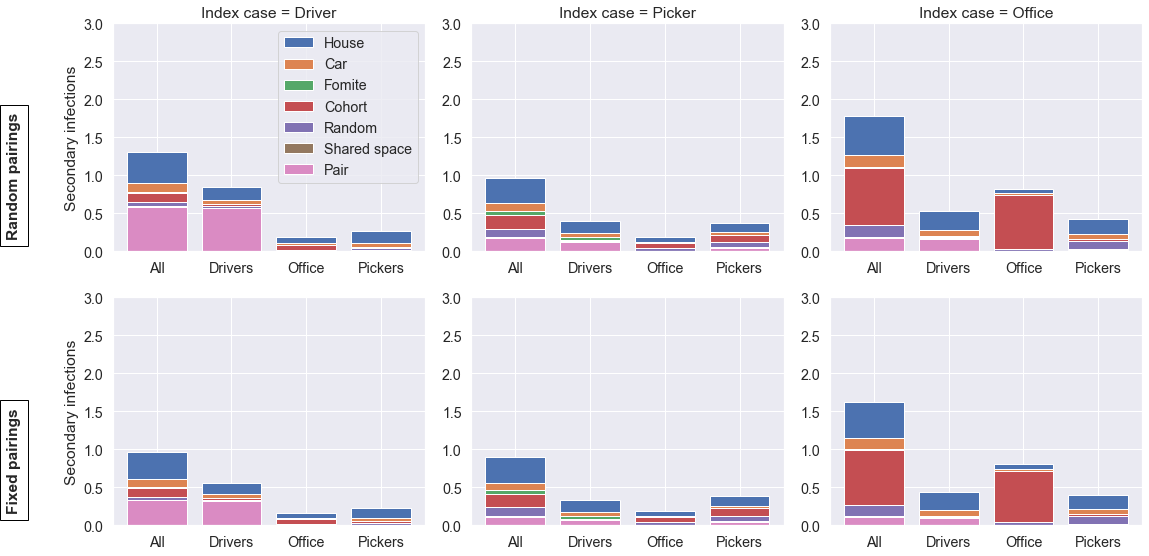

In [6]:
fig,ax = plt.subplots(2,3,figsize=(16,8))    
for j in np.arange(3):
    for k in [0,1]:
        l = 0
        ax[k,j].bar(jobtypes, netinfs[:,j,k,l]+continfs[:,j,k,l]+\
                          roominfs[:,j,k,l]+pairinfs[:,j,k,l]+\
                          fomiteinfs[:,j,k,l] + carinfs[:,j,k,l]+\
                          houseinfs[:,j,k,l],label='House')
        ax[k,j].bar(jobtypes, netinfs[:,j,k,l]+continfs[:,j,k,l]+\
                          roominfs[:,j,k,l]+pairinfs[:,j,k,l]+\
                          fomiteinfs[:,j,k,l] + carinfs[:,j,k,l],label='Car')
        ax[k,j].bar(jobtypes, netinfs[:,j,k,l]+continfs[:,j,k,l]+\
                          roominfs[:,j,k,l]+pairinfs[:,j,k,l]+\
                          fomiteinfs[:,j,k,l],label='Fomite')
        ax[k,j].bar(jobtypes, netinfs[:,j,k,l]+continfs[:,j,k,l]+\
                          roominfs[:,j,k,l]+pairinfs[:,j,k,l],label='Cohort')
        ax[k,j].bar(jobtypes, continfs[:,j,k,l]+\
                          roominfs[:,j,k,l]+pairinfs[:,j,k,l],label='Random')
        ax[k,j].bar(jobtypes, roominfs[:,j,k,l]+pairinfs[:,j,k,l],label='Shared space')
        ax[k,j].bar(jobtypes, pairinfs[:,j,k,l],label='Pair')
        ax[k,j].set_ylim((0,3.0))
        ax[k,0].set_ylabel('Secondary infections')

        
    ax[0,j].set_title('Index case = %s'%job[j])
ax[0,0].text(-2.0, 0.2, 'Random pairings', rotation='vertical',fontweight='bold',\
            bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 7.0, 'linestyle': '-',\
                  'edgecolor': 'black'})
ax[1,0].text(-2.0, 0.2, 'Fixed pairings', rotation='vertical',fontweight='bold',\
            bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 7.0, 'linestyle': '-',\
                  'edgecolor': 'black'})
ax[0,0].legend()
fig.tight_layout()
fig.savefig('pair_infection_routes.png')

In [7]:
print(dfall.columns)

Index(['Group', 'NStaff', 'Iteration', 'FracRecovered', 'FomiteInfectionFrac',
       'CohortInfectionFrac', 'RandContactInfectionFrac', 'PairInfectionFrac',
       'RoomInfectionFrac', 'ExtIntroFrac', 'CustIntroFrac', 'CarShareInfFrac',
       'HouseShareInfFrac', 'CustomersInfected', 'IsolatorsFrac',
       'SympIsolatorsFrac', 'FPIsolatorsFrac', 'TPSympIsolatorsFrac',
       'TPAsympIsolatorsFrac', 'IndexCaseInfections', 'IndexCaseViralLoad',
       'IndexCaseInfectivity', 'OverallOutbreakLength', 'fixed_loader_pairs',
       'Dtime', 'Ltime', 'fixed_driver_pairs', 'tD', 'SimType',
       'BreakContactProb', 'TeamTimes', 'PkgHlife', 'phi', 'TeamDistances',
       'is_driver_pairs', 'InfInit', 'HouseShareFactor', 'CarShareFactor',
       'Psusc', 'Pisol', 'NDteams', 'is_cohorts', 'is_loader_pairs',
       'p_contact', 'CohortChangeRate', 'p_fomite_trans', 'is_window_open',
       'NOteams', 'TeamsOutside', 'NLteams', 'NRecovered', 'outbreak',
       'Ninfected', 'InfJob'],
      dtyp

In [8]:
dfall["Scenario"] = np.zeros(len(dfall),dtype=np.object)
dfall.loc[lambda dfall: ((dfall['fixed_driver_pairs'] == False) & \
                        (dfall['is_window_open'] == False)), 'Scenario'] = "No intervention"
dfall.loc[lambda df: ((df['fixed_driver_pairs'] == True) & \
                     (df['is_window_open'] == False)), 'Scenario'] = "Fixed pairings"
dfall.loc[lambda df: ((df['fixed_driver_pairs'] == False) & \
                      (df['is_window_open'] == True)),'Scenario'] = "Windows open"
dfall.loc[lambda df: ((df['fixed_driver_pairs'] == True) & \
                      (df['is_window_open'] == True)),'Scenario'] = "FP + WO"

/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
dfall['outbreak'] = (dfall['NRecovered'] > 3)
dfall['Ninfected'] = (dfall.loc[:,'FracRecovered']*dfall.loc[:,'NStaff'] - 1)
dfreduced = dfall.loc[lambda df: ((df['Scenario'] != 0) & \
                      (df['NDteams'] == 3) & (df['NLteams'] == 2) &(df['NOteams'] == 1))]


/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


        

Index case to outbreak relation

/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


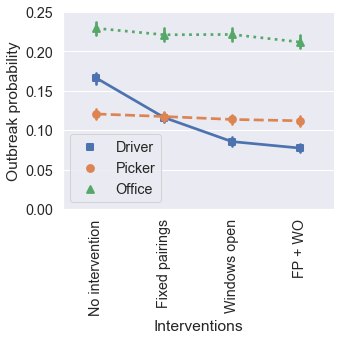

In [10]:
sns.set_color_codes()



jobno = np.array(dfreduced['InfInit'].to_numpy()-1,dtype=int)
jobs = np.array(job)
dfreduced['Jobinit'] = jobs[jobno]
sp = sns.catplot(x='Scenario',y='outbreak', hue='Jobinit',data=dfreduced, kind='point',
                 order=['No intervention','Fixed pairings','Windows open','FP + WO'],
                 markers=["s","o","^","D"], linestyles=["-", "--",":","-."], 
                 legend=False)
sp.set(ylim=(0,0.25),xlabel='Interventions')
axes = sp.axes.flatten()
axes[0].set_ylabel('Outbreak probability')
lab = ['a','b','c']
sp.set_xticklabels(rotation=90)
axes[0].legend(loc='lower left')
plt.tight_layout()
sp.savefig('Outbreak_prob_pairs.png')

In [11]:
# sns.set_color_codes()
# sp = sns.catplot(x='NDteams',y='outbreak', hue='Scenario',col='InfInit',data=dfall,kind='point',
#                  hue_order=['No intervention','Windows open','Fixed pairings','FP + WO'],\
#                  markers=["s","o","^","D"], linestyles=["-", "--",":","-."],legend=False)
# sp.set(ylim=(0,0.4),xlabel='Driver contact rate')
# axes = sp.axes.flatten()
# axes[0].set_ylabel('No. of secondary cases')
# lab = ['a','b','c']
# for i in range(3):
#     axes[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
# sp.set_xticklabels(rotation=90)
# plt.legend(loc='upper right')
# plt.tight_layout()
# sp.savefig('Outbreak_prob_pairs_NDT.png')

In [12]:
# sp = sns.catplot(x='NLteams',y='outbreak', hue='Scenario',col='InfInit',data=dfall,kind='point',
#                  hue_order=['No intervention','Windows open','Fixed pairings','FP + WO'],
#                  markers=["s","o","^","D"], linestyles=["-", "--",":","-."], legend=False)
# sp.set(ylim=(0,0.4,xlabel='Number of picker teams')
# axes = sp.axes.flatten()
# axes[0].set_ylabel('Outbreak probability')
# lab = ['a','b','c']
# for i in range(3):
#     axes[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
# sp.set_xticklabels(rotation=90)
# axes[1].legend(loc='upper right')
# plt.tight_layout()
# sp.savefig('Outbreak_prob_pairs_NLT.png')

In [13]:
# sp = sns.catplot(x='NOteams',y='outbreak', hue='Scenario',col='InfInit',data=dfall,kind='point',
#                  hue_order=['No intervention','Windows open','Fixed pairings','FP + WO'],
#                  markers=["s","o","^","D"], linestyles=["-", "--",":","-."], legend=False)
# sp.set(ylim=(0,0.4),xlabel='Number of office teams')
# axes = sp.axes.flatten()
# axes[0].set_ylabel('Outbreak probability')
# lab = ['a','b','c']
# for i in range(3):
#     axes[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
# sp.set_xticklabels(rotation=90)
# axes[2].legend(loc='upper right')
# plt.tight_layout()
# sp.savefig('Outbreak_prob_pairs_NOT.png')

/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


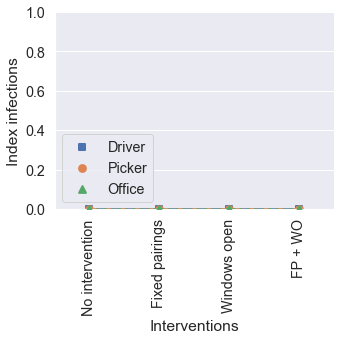

In [14]:
sns.set_color_codes()

jobno = np.array(dfreduced['InfInit'].to_numpy()-1,dtype=int)
jobs = np.array(job)
dfreduced['Jobinit'] = jobs[jobno]
sp = sns.catplot(x='Scenario',y='IndexCaseInfections', hue='Jobinit',data=dfreduced, kind='point',
                 order=['No intervention','Fixed pairings','Windows open','FP + WO'],
                 markers=["s","o","^","D"], linestyles=["-", "--",":","-."], 
                 legend=False)
sp.set(ylim=(0,1.0),xlabel='Interventions')
axes = sp.axes.flatten()
axes[0].set_ylabel('Index infections')
lab = ['a','b','c']
sp.set_xticklabels(rotation=90)
axes[0].legend(loc='lower left')
plt.tight_layout()

customer infections

/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


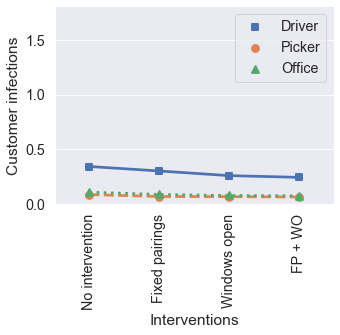

In [15]:
sns.set_color_codes()

jobno = np.array(dfreduced['InfInit'].to_numpy()-1,dtype=int)
jobs = np.array(job)
dfreduced['Jobinit'] = jobs[jobno]
sp = sns.catplot(x='Scenario',y='CustomersInfected', hue='Jobinit',data=dfreduced, kind='point',
                 order=['No intervention','Fixed pairings','Windows open','FP + WO'],
                 markers=["s","o","^","D"], linestyles=["-", "--",":","-."], 
                 legend=False)
sp.set(ylim=(0,1.8),xlabel='Interventions')
axes = sp.axes.flatten()
axes[0].set_ylabel('Customer infections')
lab = ['a','b','c']
sp.set_xticklabels(rotation=90)
axes[0].legend(loc='upper right')
plt.tight_layout()
sp.savefig('Customer_infections_pairs.png')

/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


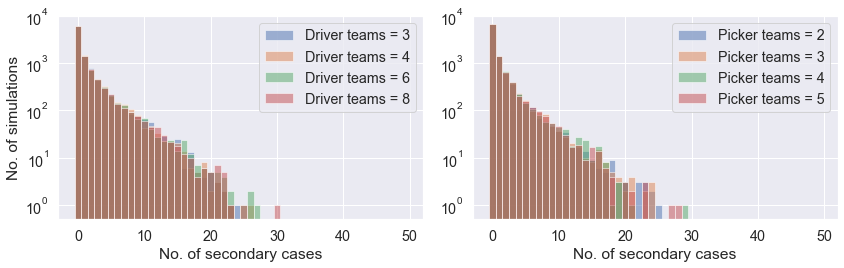

In [16]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ntd = 2
nphi = 0
for td in NDteams:
    dfh = dfall[(dfall['InfInit'] == 1)*(dfall['NDteams']==td)*(dfall['NLteams']==2)*\
                (dfall['NOteams']==1)*(dfall['TeamDistances']<1.5)*
                (dfall['Scenario']=="No intervention")]
    ax[0].hist(dfh['Ninfected'],bins=(np.arange(51)-0.5),label='Driver teams = %d'%(td),alpha=0.5)
for tl in NLteams:
    dfh = dfall[(dfall['InfInit'] == 2)*(dfall['NDteams']==3)*(dfall['NLteams']==tl)*\
                (dfall['NOteams']==1)*(dfall['TeamDistances']<1.5)*
                (dfall['Scenario']=="No intervention")]
    ax[1].hist(dfh['Ninfected'],bins=(np.arange(51)-0.5),label='Picker teams = %d'%(tl),alpha=0.5)
for i in [0,1]:    
    ax[i].set_yscale('log')
    ax[i].set_ylim((0.5,10000))
    ax[i].set_xlabel('No. of secondary cases')
    ax[i].legend()
ax[0].set_ylabel('No. of simulations')

fig.tight_layout()
fig.savefig('secondary_cases_hist_pairs.png')

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,4))
ntd = 2
nphi = 0
for (i,II) in enumerate(np.array([1,2,3])):
    dfh = dfreduced[(dfreduced['InfInit'] == II)&(dfreduced['Scenario']=="No intervention")]
    ax[i].hist(dfh['Ninfected'],bins=(np.arange(45)-0.5),label="No intervention")
    dfh = dfreduced[(dfreduced['InfInit'] == II)&(dfreduced['Scenario']=="Fixed pairings")]
    ax[i].hist(dfh['Ninfected'],bins=(np.arange(45)-0.5),label="Fixed Pairings",alpha=0.4)
    dfh = dfreduced[(dfreduced['InfInit'] == II)&(dfreduced['Scenario']=="FP + WO")]
    ax[i].hist(dfh['Ninfected'],bins=(np.arange(45)-0.5),label="FP+WO",alpha=0.4)   
    ax[i].set_yscale('log')
    ax[i].set_ylim((1,10000))
    ax[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
    ax[i].set_xlabel('No. of secondary cases')
ax[0].set_ylabel('No. of simulations')
fig.tight_layout()
ax[2].legend(loc='upper right')
fig.savefig('secondary_cases_hist_pairs2.png')

In [16]:
?sns.lineplot

Signature:
sns.lineplot(
    x=None,
    y=None,
    hue=None,
    size=None,
    style=None,
    data=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    sizes=None,
    size_order=None,
    size_norm=None,
    dashes=True,
    markers=None,
    style_order=None,
    units=None,
    estimator='mean',
    ci=95,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    err_kws=None,
    legend='brief',
    ax=None,
    **kwargs,
)
Docstring:
Draw a line plot with possibility of several semantic groupings.

The relationship between ``x`` and ``y`` can be shown for different subsets
of the data using the ``hue``, ``size``, and ``style`` parameters. These
parameters control what visual semantics are used to identify the different
subsets. It is possible to show up to three dimensions independently by
using all three semantic types, but this style of plot can be hard to
interpret and is often ineffective. Using redundant semantics (i.e. both
``hue`` and ``styl